In [1]:
# Import the necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model # Model is useful to edit the layers of an existing model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

Using TensorFlow backend.


In [2]:
# Setting the dimensions of our images.

img_width, img_height = 224, 224

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

nb_train_samples = 600
nb_validation_samples = 120

epochs = 10   # we won't be using 20 epochs. Here 5 epochs is enough. Due to the complexity of the model, learning is slow
batch_size = 15

In [3]:
# Setting the input shape format: 3 is the color channels (RGB)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [4]:
# Loading the vgg16 model from keras with imagenet weights, setting the input shape to our interests 

vgg = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                               input_tensor=None, input_shape=(224,224,3), pooling=None) #could write input_shape=input_shape
vgg.summary()        

W0829 21:57:56.473425  2404 deprecation_wrapper.py:119] From C:\Users\atuls\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 21:57:57.172471  2404 deprecation_wrapper.py:119] From C:\Users\atuls\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 21:57:57.188075  2404 deprecation_wrapper.py:119] From C:\Users\atuls\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 21:57:57.245811  2404 deprecation_wrapper.py:119] From C:\Users\atuls\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4255: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0829 21:58:00.528175  2404 deprecation_wrapper.py:119] From C:\Users\atuls\Ana

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Freeze the layers so that they are not trained during model fitting. We want to keep the imagenet weights
for layer in vgg.layers: 
    layer.trainable=False

In [6]:
# Change the final dense layer to 1 node (sigmoid activation) for binary classification
# could do 2 nodes and determine the probabilities of each class using SoftMax, but we used Sigmoid for our simple ConvNet
x = vgg.layers[-2].output
output_layer = Dense(1, activation='sigmoid', name='predictions')(x)

In [7]:
# Combine the output layer to the original model
vgg_binary = Model(inputs=vgg.input, outputs=output_layer)

In [8]:
# Sanity check: Print out the model summary. The final layer should have 1 neuron only (again, using sigmoid activation)
vgg_binary.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [9]:
# Compile the modified vgg model with the following hyperparameters (same as simple ConvNet)
# In future try different learning rates for the adam 'adaptive moment estimation'
vgg_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W0829 21:59:25.645832  2404 deprecation_wrapper.py:119] From C:\Users\atuls\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 21:59:25.671627  2404 deprecation.py:323] From C:\Users\atuls\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Defining Image transformations: normalization (rescaling) for both training and testing images
# Defining Image transformations: Augmenting the training data with the following transformations 
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Setting up the flow of images in batches for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Printing out the class labels for both training and validation sets
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 600 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
{'Buddha': 0, 'Ganesha': 1}
{'Buddha': 0, 'Ganesha': 1}


In [12]:
# Fitting the modified vgg16 model on the image batches set up in the previous step
# Save the model (full model). Save the training history
history = vgg_binary.fit_generator(
        train_generator,
        steps_per_epoch=600 // batch_size,
        epochs=epochs,                           # changed epochs=epochs to 5, larger model and thus takes more time to train
        validation_data=validation_generator,
        validation_steps=120 // batch_size)

vgg_binary.save('vgg_binary.h5')
print("Saved vgg16 model to disk") # the modlsize is over 500MB

# As you can see, each epoch is taking ~10 minutes. The loss is going down with each epoch. The model also generalizes well
# the accuracy on the validation set is mirroring that of training set, actually it is better on the validation set.

Epoch 1/10
40/40 [==============================] - 180s 5s/step - loss: 0.7651 - acc: 0.5900 - val_loss: 0.6319 - val_acc: 0.5833
Epoch 2/10
40/40 [==============================] - 178s 4s/step - loss: 0.5893 - acc: 0.6700 - val_loss: 0.4870 - val_acc: 0.7667
Epoch 3/10
40/40 [==============================] - 176s 4s/step - loss: 0.4937 - acc: 0.7783 - val_loss: 0.5033 - val_acc: 0.7167
Epoch 4/10
40/40 [==============================] - 179s 4s/step - loss: 0.4509 - acc: 0.8183 - val_loss: 0.4034 - val_acc: 0.8083
Epoch 5/10
40/40 [==============================] - 170s 4s/step - loss: 0.4363 - acc: 0.8183 - val_loss: 0.3820 - val_acc: 0.8250
Epoch 6/10
40/40 [==============================] - 178s 4s/step - loss: 0.4104 - acc: 0.8167 - val_loss: 0.3712 - val_acc: 0.8333
Epoch 7/10
40/40 [==============================] - 176s 4s/step - loss: 0.4152 - acc: 0.8083 - val_loss: 0.3698 - val_acc: 0.8417
Epoch 8/10
40/40 [==============================] - 177s 4s/step - loss: 0.3788 - a

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


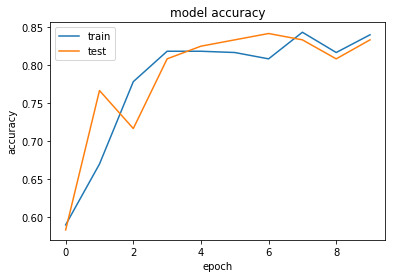

In [13]:
# Print out the metrics recorded during training (saved in the history)
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# As we can see the accuracy is improving as we train through the epochs. At the end we see it is elbowing
# The model might do well if we increase the training epochs, or change the architecture of the model by using the 
# bottleneck features of the vgg model and defining our own flattening and fully connected dense layers at the end
# for prediction. I will do that in a different notebook, but wll use less images for training the model

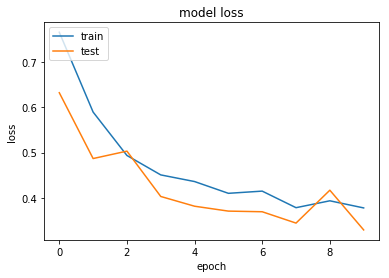

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# As I mentioned before, the loss is going down at each epoch of training 